In [1]:
# Import packages
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.distributed
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from collections import OrderedDict
from torchtext import vocab # This package can give problems sometimes, it may be necessary to downgrade to a specific version
import seaborn as sns
import random
from random import choice
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn import metrics
import os
import pickle
from functions import (load_reward_model, identify_mutations_and_count, generate_df, generate_and_evaluate_mutants, generate_and_evaluate_mutants_max_sampling,
    mutate_sequences_after_training, mutate_sequences_after_training_esm2_max_sampling, get_sft_version_file)
from dataloading_RLXF_ESM2 import (ProtDataModuleESM2, ProtRepDatasetESM2)
from PPO_ESM2_650M_with_model_saving_DDP import RLXF_PPO_ESM2
from transformers import AutoModelForMaskedLM, AutoTokenizer
from MLP import MLP
import itertools
import copy
import warnings
import optuna
import logging
import sys
from optuna.exceptions import TrialPruned
from pytorch_lightning.callbacks import Callback
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# from esm.models.esmc import ESMC
# from esm.sdk.api import ESMProtein, LogitsConfig
# from esm.sdk.forge import ESM3ForgeInferenceClient

In [2]:
# Define amino acid dictionary for tokenization, define WT for length of context window
AAs = 'ACDEFGHIKLMNPQRSTVWY' # setup torchtext vocab to map AAs to indices, usage is aa2ind(list(AAsequence))
WT = 'MAGLRHTFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFLQGEGTDPKEVQKIRDAIKKGEACSVRLLNYRKDGTPFWNLLTVTPIKTPDGRVSKFVGVQVDVTSKTEGKALA' # CreiLOV
aa2ind = vocab.vocab(OrderedDict([(a, 1) for a in AAs]))
aa2ind.set_default_index(20) # set unknown charcterers to gap
sequence_length = len(WT)

# Parameters
num_EnsMLPs = 100  # We have 100 reward models
num_designs = 1000
seed = 7028


In [3]:
# Create histogram
model_identifiers = ['VAE', 'esm2_t36_3B_UR50D', 'esm2_t33_650M_UR50D', 'esm2_t30_150M_UR50D', 'esm2_t12_35M_UR50D', 'esm2_t6_8M_UR50D', 'esmc_300m', 'esmc_600m', 'esmc-6b-2024-12']
all_fixed_scores = {}  # Dictionary to store scores for each model

for model_identifier in model_identifiers:
    if model_identifier == 'VAE':
        df_fixed = pd.read_csv('/Users/nathanielblalock/Desktop/RLXF_Projects/designs/vae_designs/version_507/fixed_vae_designs_scores_507.csv')
        fixed_scores_np = df_fixed['Score']
        all_fixed_scores[model_identifier] = fixed_scores_np

    else:
        # Load mutants and scores
        fixed_scores_np = np.load(f'./logs/fixed_scores_{model_identifier}.npy')
        
        # Store scores in dictionary
        all_fixed_scores[model_identifier] = np.median(fixed_scores_np, axis=0)



In [4]:
# Constants
alpha = 1
predicted_wt_score = 4.1498  # predicted WT score
WT_linewidth = 2
linewidth = 1
fill = False

# Define model groups sorted from smallest to largest:
esm2_models = ['esm2_t6_8M_UR50D',    # 8M (smallest)
               'esm2_t12_35M_UR50D',   # 35M
               'esm2_t30_150M_UR50D',  # 150M
               'esm2_t33_650M_UR50D',  # 650M
               'esm2_t36_3B_UR50D']    # 3B (largest)

# For esmc, sort from smallest to largest:
esmc_models = ['esmc_300m',  # 300M
               'esmc_600m',  # 600M
               'esmc-6b-2024-12']  # 6B

# VAE
vae_models = ['VAE'] # 2.1M

# New overall ordering:
new_order = esm2_models + esmc_models + vae_models

# Update model_size_labels: for esm2 and esmc use their size string, for VAE use "2M"
model_size_labels = {
    'esm2_t36_3B_UR50D': '3B',
    'esm2_t33_650M_UR50D': '650M',
    'esm2_t30_150M_UR50D': '150M',
    'esm2_t12_35M_UR50D': '35M',
    'esm2_t6_8M_UR50D': '8M',
    'esmc-6b-2024-12': '6B',
    'esmc_600m': '600M',
    'esmc_300m': '300M',
    'VAE': '2M'
}

# Colors and color map (ordered according to new_order)
colors = ['#2166ac', '#2166ac', '#2166ac', '#2166ac', '#2166ac',
          '#b2182b', '#b2182b', '#b2182b',
          '#bdbdbd']
color_map = {model: color for model, color in zip(new_order, colors)}


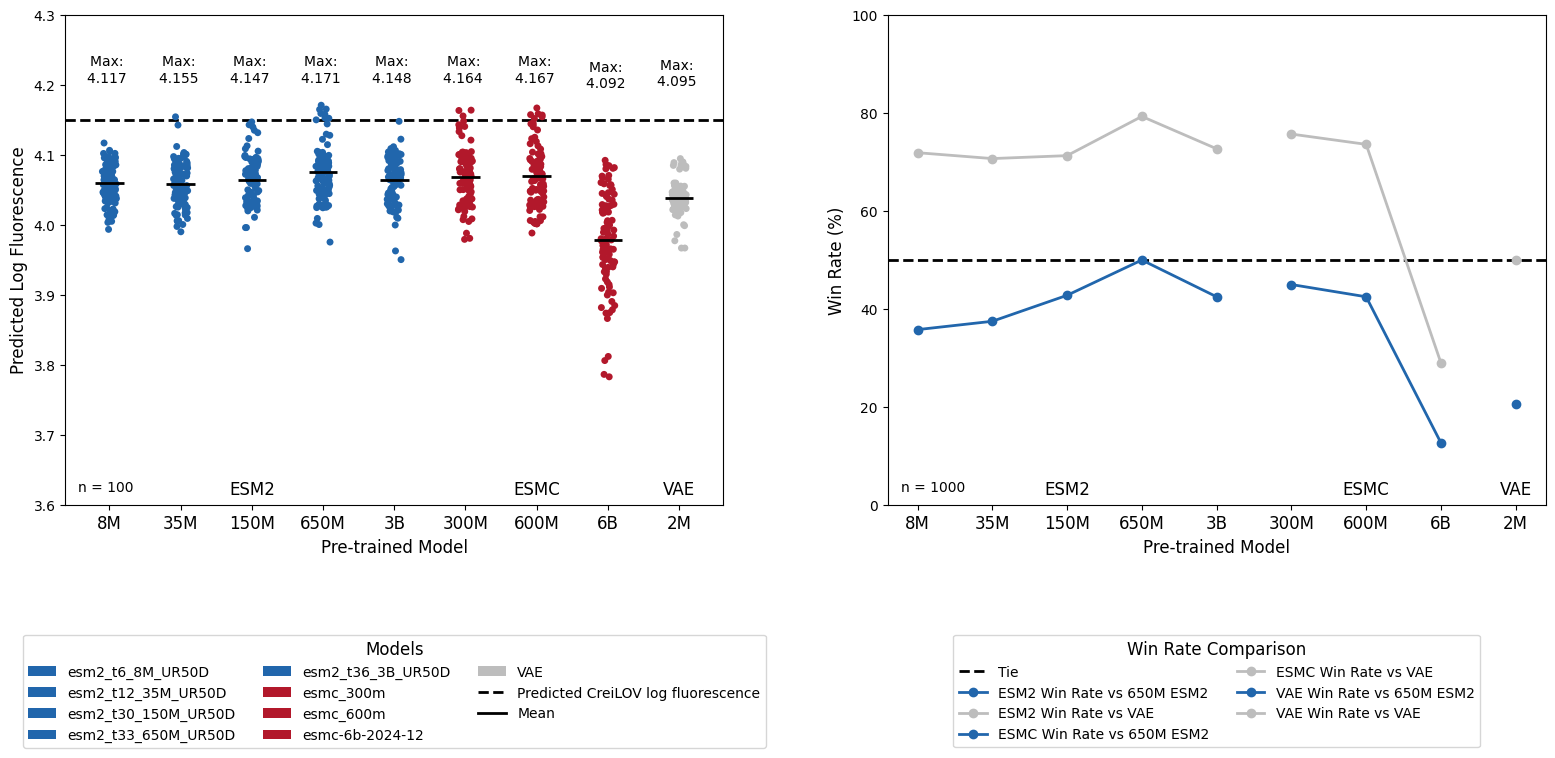

In [5]:
# ---------------------------
# Create figure and subplots
# ---------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# ====================================================
# Subplot 1: Stripplot of fixed scores with group delimiters (n=100)
# ====================================================
data_to_plot = [np.array(all_fixed_scores[m])[:100] for m in new_order]

# Plot the stripplot with jitter
sns.stripplot(
    data=data_to_plot,
    ax=ax1,
    palette=[color_map[m] for m in new_order],
    jitter=True  # Adds some horizontal spread to avoid overlapping points
)

# Add mean bar for each group (drawn after the stripplot so they appear in front)
for i, scores in enumerate(data_to_plot):
    mean_val = np.mean(scores)
    ax1.hlines(mean_val, i - 0.2, i + 0.2, colors='black', linestyles='-', lw=WT_linewidth, zorder=10)

# Add predicted wild-type score line
ax1.axhline(predicted_wt_score, color='black', linestyle='--',
            linewidth=WT_linewidth, label='Predicted CreiLOV log fluorescence')

# Set y-axis limits to range from 3.6 to 4.3
ax1.set_ylim(3.6, 4.3)

# Set x-tick labels as each model's size label
xtick_labels = [model_size_labels[m] for m in new_order]
ax1.set_xticks(np.arange(len(new_order)))
ax1.set_xticklabels(xtick_labels, fontsize=12)
ax1.set_xlabel('Pre-trained Model', fontsize=12)
ax1.set_ylabel('Predicted Log Fluorescence', fontsize=12)

# Add group labels beneath the x-axis.
ax1.text(2, 0.05, 'ESM2', transform=ax1.get_xaxis_transform(),
         ha='center', va='top', fontsize=12)
ax1.text(6, 0.05, 'ESMC', transform=ax1.get_xaxis_transform(),
         ha='center', va='top', fontsize=12)
ax1.text(8, 0.05, 'VAE', transform=ax1.get_xaxis_transform(),
         ha='center', va='top', fontsize=12)

# Add text annotations above each set with the max value from the sampled scores.
for i, scores in enumerate(data_to_plot):
    max_val = np.max(scores)
    y_offset = 0.1
    y_pos = min(max_val + y_offset, 4.2)  # keep within y-limit
    ax1.text(i, y_pos, f"Max: \n{max_val:.3f} ", ha='center', va='bottom', fontsize=10, color='black')

# Create legend handles for the models.
model_handles = [Patch(facecolor=color_map[m], label=m) for m in new_order]

# Create a handle for the predicted wild-type line.
wt_line_handle = Line2D([0], [0], color='black', linestyle='--', linewidth=WT_linewidth,
                          label='Predicted CreiLOV log fluorescence')

# Create a handle for the mean line.
mean_line_handle = Line2D([0], [0], color='black', linestyle='-', linewidth=WT_linewidth, label='Mean')

# Place the legend beneath subplot 1.
ax1.legend(handles=model_handles + [wt_line_handle, mean_line_handle],
           title="Models", loc='upper center', bbox_to_anchor=(0.5, -0.25),
           ncol=3, fontsize=10, title_fontsize=12)

# Add annotation for sample size on subplot 1
ax1.text(0.02, 0.05, "n = 100", transform=ax1.transAxes,
         fontsize=10, color='black', va='top')

# ====================================================
# Subplot 2: Win Rate by Model Size with baseline and trend lines (n=1000)
# ====================================================

# Sample 1000 points for win rate computation
win_rate_sample = {
    m: np.array(all_fixed_scores[m])
    for m in new_order
}

# Compute win rate data using the 1000-sample data
win_rate_data = []
for model in new_order:
    data = win_rate_sample[model]
    
    # Compute win rate vs VAE using win_rate_sample
    if "VAE" in win_rate_sample and model != "VAE":
        win_rate_vae = np.mean(data > win_rate_sample["VAE"]) * 100
        win_rate_data.append({'Model': model,
                              'Comparison': 'Win Rate vs VAE',
                              'Value': win_rate_vae})
    elif "VAE" in win_rate_sample and model == "VAE":
        win_rate_data.append({'Model': model,
                              'Comparison': 'Win Rate vs VAE',
                              'Value': 50})
    
    # Compute win rate vs 650M ESM2 using win_rate_sample
    if "esm2_t33_650M_UR50D" in win_rate_sample and model != "esm2_t33_650M_UR50D":
        win_rate_esm2 = np.mean(data > win_rate_sample["esm2_t33_650M_UR50D"]) * 100
        win_rate_data.append({'Model': model,
                              'Comparison': 'Win Rate vs 650M ESM2',
                              'Value': win_rate_esm2})
    elif "esm2_t33_650M_UR50D" in win_rate_sample and model == "esm2_t33_650M_UR50D":
        win_rate_data.append({'Model': model,
                              'Comparison': 'Win Rate vs 650M ESM2',
                              'Value': 50})

# Update the 'Size' column using the revised model_size_labels mapping.
df_win = pd.DataFrame(win_rate_data)
df_win['Size'] = df_win['Model'].map(model_size_labels)

# Add a 'Group' column to help with trend lines.
def get_group(model):
    if model.startswith('esm2'):
        return 'ESM2'
    elif model.startswith('esmc'):
        return 'ESMC'
    elif model == 'VAE':
        return 'VAE'
df_win['Group'] = df_win['Model'].apply(get_group)

# Define win rate x-axis order based on new_order:
win_size_order = [model_size_labels[m] for m in new_order]  

# Create a mapping from size label to numeric x positions.
positions = {size: i for i, size in enumerate(win_size_order)}

# Define a comparison palette (using the baseline colors from our color_map)
comp_palette = {
    "Win Rate vs VAE": color_map["VAE"],
    "Win Rate vs 650M ESM2": color_map["esm2_t33_650M_UR50D"]
}

# Add group labels beneath the x-axis.
ax2.text(2, 0.05, 'ESM2', transform=ax2.get_xaxis_transform(),
         ha='center', va='top', fontsize=12)
ax2.text(6, 0.05, 'ESMC', transform=ax2.get_xaxis_transform(),
         ha='center', va='top', fontsize=12)
ax2.text(8, 0.05, 'VAE', transform=ax2.get_xaxis_transform(),
         ha='center', va='top', fontsize=12)

# Draw the baseline as a black dashed line at 50% and capture its handle.
baseline_handle = ax2.axhline(50, color='black', linestyle='--', linewidth=WT_linewidth, label='Baseline')

# Add trend lines connecting win rate points for each (Group, Comparison).
line_handles = {}
for (group, comp), subdf in df_win.groupby(['Group', 'Comparison']):
    subdf = subdf.copy()
    subdf['x'] = subdf['Size'].apply(lambda s: positions[s])
    subdf = subdf.sort_values('x')
    label = f"{group} {comp}"
    line, = ax2.plot(subdf['x'], subdf['Value'], color=comp_palette[comp],
                     linestyle='-', linewidth=2, marker='o')
    line_handles[label] = line

# Reset x-axis ticks and labels to show the size strings.
ax2.set_xticks(range(len(win_size_order)))
ax2.set_xticklabels(win_size_order, fontsize=12)
ax2.set_xlabel('Pre-trained Model', fontsize=12)
ax2.set_ylabel('Win Rate (%)', fontsize=12)
ax2.set_ylim(0, 100)

# Place the legend for subplot 2 beneath the axes, including the baseline.
legend_handles = [baseline_handle] + list(line_handles.values())
legend_labels = ['Tie'] + list(line_handles.keys())
ax2.legend(handles=legend_handles, labels=legend_labels,
           title="Win Rate Comparison", loc='upper center', bbox_to_anchor=(0.5, -0.25),
           ncol=2, fontsize=10, title_fontsize=12)

# Add annotation for sample size on subplot 2
ax2.text(0.02, 0.05, "n = 1000", transform=ax2.transAxes,
         fontsize=10, color='black', va='top')

plt.tight_layout(rect=[0, 0, 1, 1])
plt.savefig('./figures/pretrained_model_design_scores.svg')
plt.savefig('./figures/pretrained_model_design_scores.png')
plt.show()


In [6]:
# Add p-sampling sequences from ESM2 650M vs not

# p-sampling sequences from ESM2 650M
dir_filepath = './logs/Aligning_SFT_ESM2s_wpPPO'
version = 12
psampling_fixed_scores_np = np.load(f'{dir_filepath}/version_{version}/fixed_esm2_t33_650M_UR50D_scores.npy')
psampling_sft_scores_np = np.load(f'{dir_filepath}/version_{version}/sft_esm2_t33_650M_UR50D_scores.npy')
psampling_rl_scores_np = np.load(f'{dir_filepath}/version_{version}/ema_aligned_esm2_t33_650M_UR50D_scores.npy')

# max-sampling sequences from ESM2 650M
max_sampling_fixed_scores_np = np.load(f'./logs/fixed_scores_esm2_t33_650M_UR50D.npy')
max_sampling_sft_scores_np = np.load(f'./logs/fixed_scores_sft_esm2_t33_650M_UR50D.npy')
max_sampling_rl_scores_np = np.load(f'./logs/fixed_scores_rl_esm2_t33_650M_UR50D.npy')

# For the boxplot we use the median (across axis=0) for each condition.
all_sampling_scores = {
    "Max Sampling: Pre-trained":    np.median(max_sampling_fixed_scores_np, axis=0),
    "Max Sampling: SFT":            np.median(max_sampling_sft_scores_np, axis=0),
    "Max Sampling: PPO":        np.median(max_sampling_rl_scores_np, axis=0),
    "P-sampling: Pre-trained":      np.median(psampling_fixed_scores_np, axis=0),
    "P-sampling: SFT":              np.median(psampling_sft_scores_np, axis=0),
    "P-sampling: PPO":          np.median(psampling_rl_scores_np, axis=0),
}

# Desired order: for each variant we show Max Sampling then P-sampling.
new_order = [
    "Max Sampling: Pre-trained",
    "Max Sampling: SFT",
    "Max Sampling: PPO",
    "P-sampling: Pre-trained",
    "P-sampling: SFT",
    "P-sampling: PPO"
]

# Define colors for each condition.
color_map = {
    "Max Sampling: Pre-trained":    "#b2182b",
    "Max Sampling: SFT":            "#b2182b",
    "Max Sampling: PPO":        "#b2182b",
    "P-sampling: Pre-trained":      "#2166ac",
    "P-sampling: SFT":              "#2166ac",
    "P-sampling: PPO":          "#2166ac"
}

# Define model_labels to extract just the variant (text after the colon)
model_labels = {key: key.split(':')[-1].strip() for key in new_order}


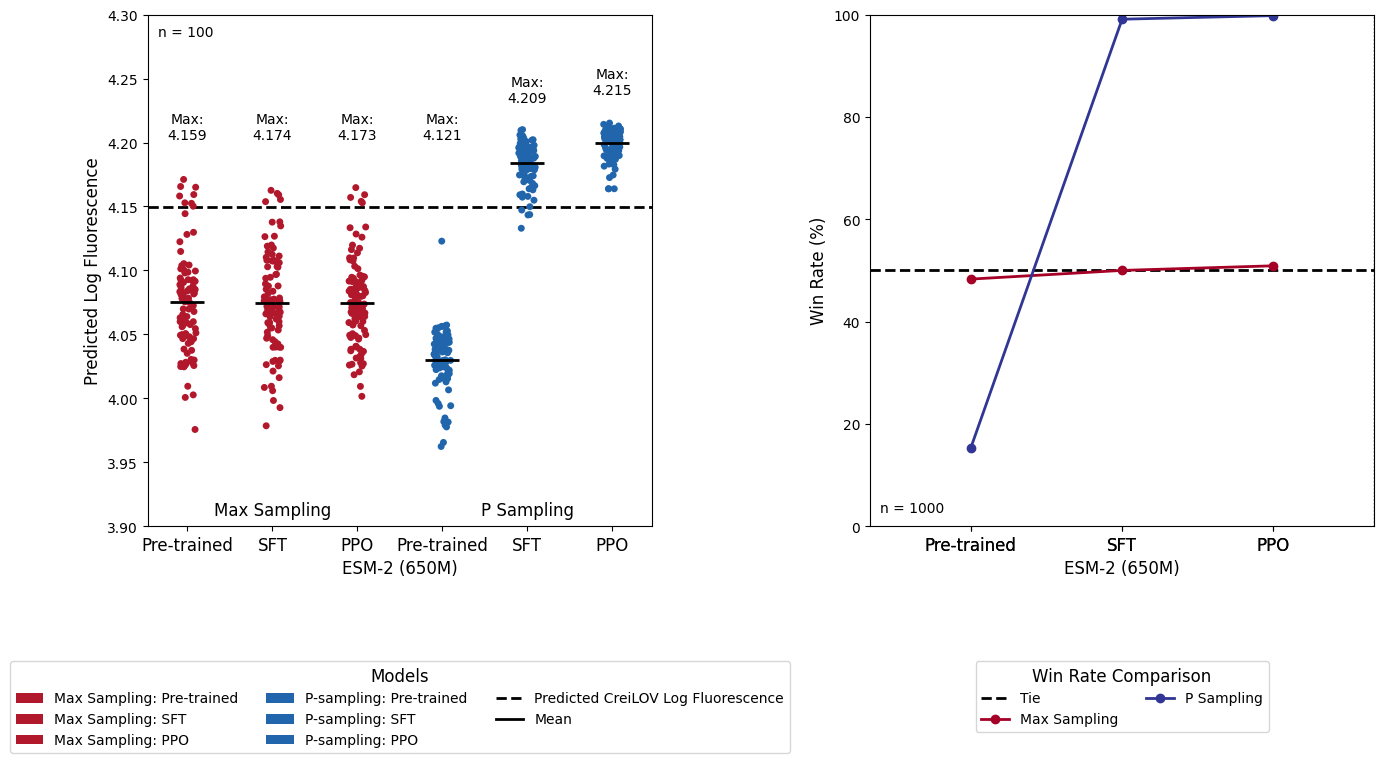

In [7]:
# ---------------------------
# Create figure and subplots
# ---------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))


# ====================================================
# Subplot 1: Stripplot of sampling scores with sample size and median annotations (n = 100)
# ====================================================
data_to_plot = [np.array(all_sampling_scores[m])[:100] for m in new_order]

# Plot the stripplot with jitter.
sns.stripplot(data=data_to_plot, ax=ax1,
              palette=[color_map[m] for m in new_order],
              jitter=True)

# Overplot the mean for each model.
for i, scores in enumerate(data_to_plot):
    mean_val = np.mean(scores)
    ax1.hlines(mean_val, i - 0.2, i + 0.2,
               colors='black', linestyles='-', lw=WT_linewidth, zorder=10)

# Add the predicted wild-type score line.
ax1.axhline(predicted_wt_score, color='black', linestyle='--',
            linewidth=WT_linewidth, label='Predicted CreiLOV Log Fluorescence')

ax1.set_ylim(3.9, 4.3)

# Set x-tick labels using model_labels.
xtick_labels = [model_labels[m] for m in new_order]
ax1.set_xticks(np.arange(len(new_order)))
ax1.set_xticklabels(xtick_labels, fontsize=12)
ax1.set_xlabel('ESM-2 (650M)', fontsize=12)
ax1.set_ylabel('Predicted Log Fluorescence', fontsize=12)

# Add sampling group labels beneath the x-axis using the axis transform.
ax1.text(1, 0.05, 'Max Sampling', transform=ax1.get_xaxis_transform(),
         ha='center', va='top', fontsize=12)
ax1.text(4, 0.05, 'P Sampling', transform=ax1.get_xaxis_transform(),
         ha='center', va='top', fontsize=12)

# Annotate each stripplot with its maximum value.
for i, model in enumerate(new_order):
    data = np.random.choice(np.array(all_sampling_scores[model]), size=100, replace=False)
    max_val = np.max(data)
    y_offset = 0.02
    y_pos = max(max_val + y_offset, 4.2)
    ax1.text(i, y_pos, f"Max:\n{max_val:.3f}", ha='center', va='bottom', fontsize=10, color='black')

# Add annotation for sample size on subplot 1
ax1.text(0.02, 0.98, "n = 100", transform=ax1.transAxes, fontsize=10, color='black', va='top')

# Build legend for subplot 1.
model_handles = [Patch(facecolor=color_map[m], label=m) for m in new_order]
wt_line_handle = Line2D([0], [0], color='black', linestyle='--', linewidth=WT_linewidth,
                        label='Predicted CreiLOV Log Fluorescence')
mean_line_handle = Line2D([0], [0], color='black', linestyle='-', linewidth=WT_linewidth,
                              label='Mean')
ax1.legend(handles=model_handles + [wt_line_handle, mean_line_handle],
           title="Models", loc='upper center', bbox_to_anchor=(0.5, -0.25),
           ncol=3, fontsize=10, title_fontsize=12)

# ====================================================
# Subplot 2: Win Rate by Model (P Sampling vs. Max Sampling per variant)
# ====================================================
# Compute win rate data comparing each model to the baseline (Max Sampling: Pre-trained)
win_rate_data = []
variants = ["Pre-trained", "SFT", "PPO"]
baseline_key = "Max Sampling: SFT"

for variant in variants:
    for model in new_order:
        if model.endswith(variant):
            if model != baseline_key:
                # Sample 100 designs for win rate computation.
                data = np.array(all_sampling_scores[model])
                baseline_data = np.array(all_sampling_scores[baseline_key])
                win_rate = 100 * np.mean(data > baseline_data)
                win_rate_data.append({
                    'Model': model,
                    'Comparison': variant,
                    'Value': win_rate
                })
            else:
                win_rate_data.append({
                    'Model': model,
                    'Comparison': variant,
                    'Value': 50
                })

df_win = pd.DataFrame(win_rate_data)

# --- Define x positions so that P-sampling points are centered in the left half and Max Sampling in the right half ---
num_variants = len(variants)
max_positions = np.linspace(1, 4, num_variants)
p_positions = max_positions

x_positions = {}
for i, variant in enumerate(variants):
    x_positions[f"P-sampling: {variant}"] = p_positions[i]
    x_positions[f"Max Sampling: {variant}"]   = max_positions[i]

# Map each model to its x position.
df_win['x'] = df_win['Model'].map(x_positions)

# Add a column for Sampling type.
df_win['Sampling'] = df_win['Model'].apply(
    lambda x: 'Max Sampling' if 'Max Sampling' in x else 'P Sampling'
)

# Draw a vertical separator between the two groups at x=5.
ax2.axvline(x=5, color='black', linestyle='dotted', linewidth=linewidth)

baseline_handle = ax2.axhline(50, color='black', linestyle='--',
                              linewidth=WT_linewidth, label='Tie')

sampling_palette = {'Max Sampling': '#a50026', 'P Sampling': '#313695'}

line_handles = {}
# Plot trend lines for each sampling type.
for sampling_type, subdf in df_win.groupby('Sampling'):
    subdf = subdf.sort_values('x')
    line, = ax2.plot(subdf['x'], subdf['Value'],
                     color=sampling_palette[sampling_type],
                     linestyle='-', linewidth=2, marker='o',
                     label=sampling_type)
    line_handles[sampling_type] = line

# Set x-axis ticks and labels.
p_xticks = p_positions   # for P-sampling
max_xticks = max_positions  # for Max Sampling
xtick_positions = np.concatenate([p_xticks, max_xticks])
xtick_labels = variants + variants

ax2.set_xticks(xtick_positions)
ax2.set_xticklabels(xtick_labels, fontsize=12)

ax2.set_xlabel('ESM-2 (650M)', fontsize=12)
ax2.set_ylabel('Win Rate (%)', fontsize=12)
ax2.set_ylim(0, 100)
ax2.set_xlim(0, 5)

# Add annotation for sample size on subplot 1
ax2.text(0.02, 0.05, "n = 1000", transform=ax2.transAxes, fontsize=10, color='black', va='top')

legend_handles = [baseline_handle] + list(line_handles.values())
legend_labels = ['Tie'] + list(line_handles.keys())
ax2.legend(handles=legend_handles, labels=legend_labels,
           title="Win Rate Comparison", loc='upper center',
           bbox_to_anchor=(0.5, -0.25), ncol=2, fontsize=10, title_fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 1])
plt.savefig('./figures/sampling_design_scores.svg')
plt.savefig('./figures/sampling_design_scores.png')
plt.show()


In [8]:
# fully fine-tuning and peft sft

# Create histogram
model_identifiers = ['esm2_t6_8M_UR50D', 'esm2_t12_35M_UR50D', 'esm2_t30_150M_UR50D', 'esm2_t33_650M_UR50D']
all_fixed_scores = {}  # Dictionary to store scores for each model
all_full_sft_scores = {}  # Dictionary to store scores for each model
all_peft_sft_scores = {}  # Dictionary to store scores for each model
all_full_rl_scores = {}  # Dictionary to store scores for each model
all_peft_rl_scores = {}  # Dictionary to store scores for each model
all_full_full_rl_scores = {}  # Dictionary to store scores for each model
all_full_peft_rl_scores = {}  # Dictionary to store scores for each model


versions = [1, 3, 4, 6]
i = 0
for model_identifier in model_identifiers:
    # Load mutants and scores
    dir_path = '../RLXF_SFT_from_pretrained_ESM2_GPU/logs/SFT_pretrained_ESM2_models'
    version = versions[i]
    fixed_scores_np = np.load(f'{dir_path}/version_{version}/fixed_{model_identifier}_scores.npy')
    all_fixed_scores[model_identifier] = np.median(fixed_scores_np, axis=0)
    i += 1
    
versions = [0, 1, 2, 3, 5, 4, 7, 6]
i = 0
for model_identifier in model_identifiers:
    # Load mutants and scores
    dir_path = '../RLXF_SFT_from_pretrained_ESM2_GPU/logs/SFT_pretrained_ESM2_models'
    
    version = versions[i]
    # print(version)
    full_sft_scores_np = np.load(f'{dir_path}/version_{version}/sft_{model_identifier}_scores.npy')
    i += 1
    
    version = versions[i]
    # print(version)
    peft_sft_scores_np = np.load(f'{dir_path}/version_{version}/sft_{model_identifier}_scores.npy')
    i += 1

    
    # Store scores in dictionary
    all_full_sft_scores[model_identifier] = np.median(full_sft_scores_np, axis=0)
    all_peft_sft_scores[model_identifier] = np.median(peft_sft_scores_np, axis=0)
    
versions = [3,2,7,6,9,8,13,12]
i = 0
for model_identifier in model_identifiers:
    # Load mutants and scores
    dir_path = './logs/Aligning_SFT_ESM2s_wpPPO'
    version = versions[i]
    # print(version)
    full_rl_scores_np = np.load(f'{dir_path}/version_{version}/ema_aligned_{model_identifier}_scores.npy')
    i += 1
    version = versions[i]
    # print(version)
    peft_rl_scores_np = np.load(f'{dir_path}/version_{version}/ema_aligned_{model_identifier}_scores.npy')
    i += 1
    
    # Store scores in dictionary
    all_full_rl_scores[model_identifier] = np.median(full_rl_scores_np, axis=0)
    all_peft_rl_scores[model_identifier] = np.median(peft_rl_scores_np, axis=0)

versions = [1,0,5,4,11,10,15,14]
i = 0
for model_identifier in model_identifiers:
    # Load mutants and scores
    dir_path = './logs/Aligning_SFT_ESM2s_wpPPO'
    version = versions[i]
    # print(version)
    full_rl_scores_np = np.load(f'{dir_path}/version_{version}/ema_aligned_{model_identifier}_scores.npy')
    i += 1
    version = versions[i]
    # print(version)
    peft_rl_scores_np = np.load(f'{dir_path}/version_{version}/ema_aligned_{model_identifier}_scores.npy')
    i += 1
    
    # Store scores in dictionary
    all_full_full_rl_scores[model_identifier] = np.median(full_rl_scores_np, axis=0)
    all_full_peft_rl_scores[model_identifier] = np.median(peft_rl_scores_np, axis=0)

# Define the conditions (in desired order)
conditions = [
    "Pre-trained",
    "SFT",
    "PEFT-SFT",
    # "PPO, SFT",
    # "PEFT-PPO, SFT",
    "PPO, PEFT-SFT",
    "PEFT-PPO, PEFT-SFT"
]

# Build a dictionary mapping each model to its condition scores.
all_scores = {}
for model in model_identifiers:
    all_scores[model] = {
        "Pre-trained":           all_fixed_scores[model],
        "SFT":                   all_full_sft_scores[model],
        "PEFT-SFT":            all_peft_sft_scores[model],
        # "PPO, SFT":          all_full_full_rl_scores[model],
        # "PEFT-PPO, SFT":   all_full_peft_rl_scores[model],
        "PPO, PEFT-SFT":   all_full_rl_scores[model],
        "PEFT-PPO, PEFT-SFT":   all_peft_rl_scores[model]
    }

# Define a color mapping for the conditions (adjust colors as desired)
color_map = {
    "Pre-trained": "#7570b3",
    "SFT": "#d95f02",
    "PEFT-SFT": "#1b9e77",
    # "PPO-SFT": "#e7298a",
    # "PEFT-PPO, SFT": "#66a61e",
    "PPO, PEFT-SFT": "#e6ab02",
    "PEFT-PPO, PEFT-SFT": "#a6761d"
}

model_labels = {
    'esm2_t6_8M_UR50D': 'ESM-2 (8M)',
    'esm2_t12_35M_UR50D': 'ESM-2 (35M)',
    'esm2_t30_150M_UR50D': 'ESM-2 (150M)',
    'esm2_t33_650M_UR50D': 'ESM-2 (650M)'
}

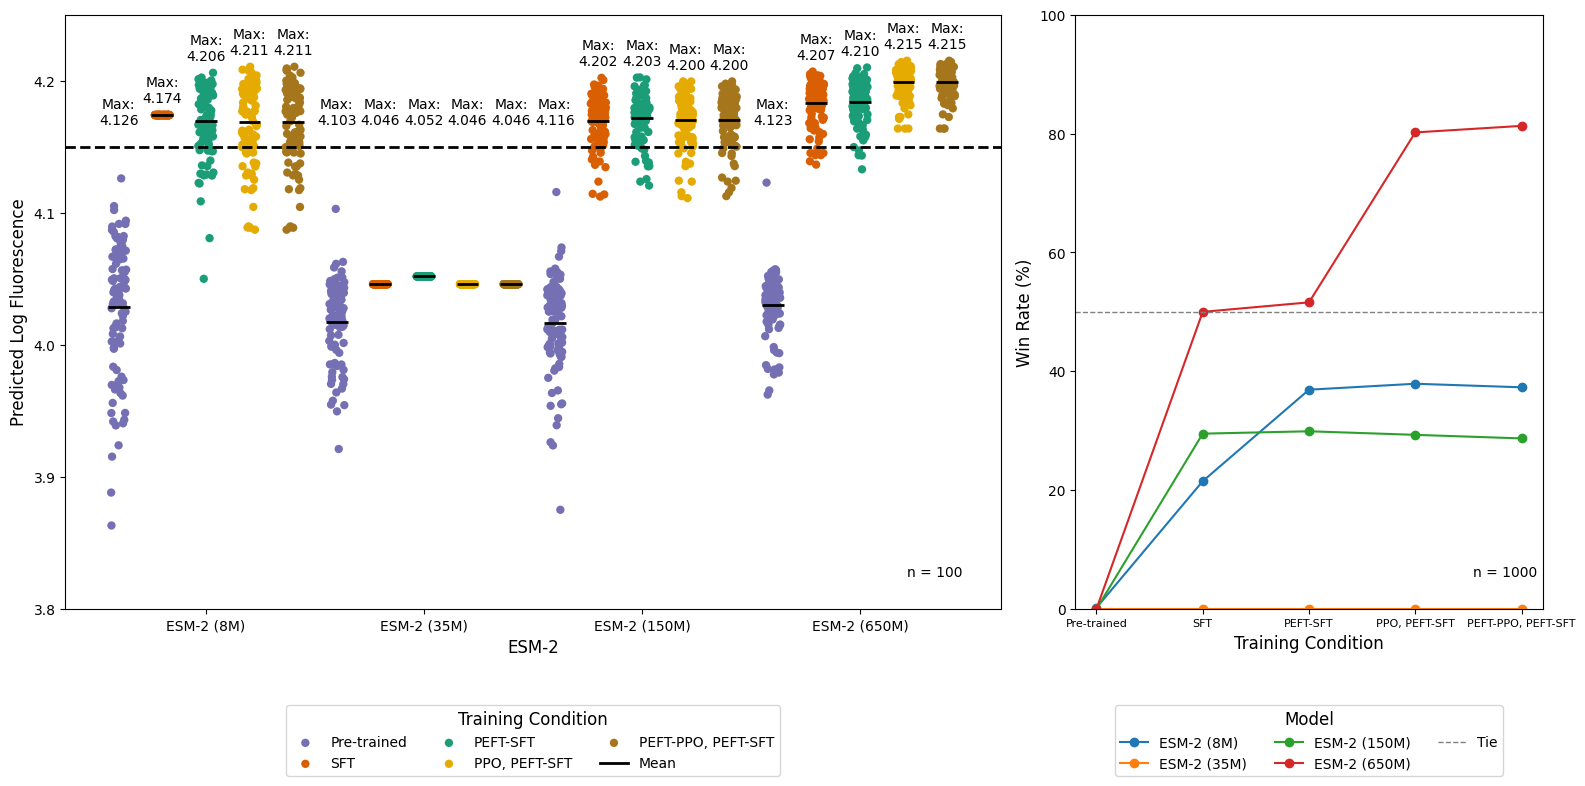

In [9]:
# Parameters for plotting
n = 100
n_win_rate = 1000

# ---------------------------
# Load data into dataframe
# ---------------------------
df_list = []
for model in model_identifiers:
    for cond in conditions:
        arr = np.array(all_scores[model][cond])[:n]
        np.random.seed(42)
        sample = arr[:n]
        temp = pd.DataFrame({'Score': sample})
        temp['Model'] = model
        temp['Condition'] = cond
        df_list.append(temp)
df_scores = pd.concat(df_list, ignore_index=True)

# Create figure and subplots with a custom width ratio: strip plot larger than win rate plot.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), gridspec_kw={'width_ratios': [2, 1]})

# -------------------------------
# Plot 1: Scatter plot of scores.
# -------------------------------
# Set up dodge offsets for conditions
width = 0.8
offsets = np.linspace(-width/2, width/2, len(conditions))
offset_dict = dict(zip(conditions, offsets))

# Prepare a dictionary to hold one scatter handle per condition (for the legend)
scatter_handles = {cond: None for cond in conditions}

# Loop over all data points and plot them with dodge and jitter.
for i, row in df_scores.iterrows():
    model = row["Model"]
    cond = row["Condition"]
    model_index = model_identifiers.index(model)
    
    # Dodge offset plus small random jitter.
    jitter = np.random.uniform(-0.035, 0.035)
    x_val = model_index + offset_dict[cond] + jitter
    color = color_map[cond]
    sc = ax1.scatter(x_val, row["Score"], color=color, edgecolors='none')
    
    # Save the first encountered scatter handle for this condition (for the legend)
    if scatter_handles[cond] is None:
        scatter_handles[cond] = sc

# Draw the predicted wild-type score line.
ax1.axhline(predicted_wt_score, color='black', linestyle='--', linewidth=WT_linewidth,
            label='Predicted CreiLOV Log Fluorescence')

# Replace x-tick labels with custom model labels.
ax1.set_xticks(np.arange(len(model_identifiers)))
ax1.set_xticklabels([model_labels[m] for m in model_identifiers], fontsize=10)
ax1.set_xlabel("ESM-2", fontsize=12)
ax1.set_ylabel("Predicted Log Fluorescence", fontsize=12)
ax1.set_ylim(3.8, 4.25)
ax1.text(0.9, 0.05, f"n = {n}", transform=ax1.transAxes, fontsize=10,
         color='black', va='bottom')

# Overlay median horizontal markers.
means = df_scores.groupby(["Model", "Condition"])["Score"].mean().reset_index()
for _, row in means.iterrows():
    i = model_identifiers.index(row["Model"])
    # x-position based on model index plus the dodge offset for this condition
    x_pos = i + offset_dict[row["Condition"]]
    # Draw a short horizontal line for the mean (adjust the length as desired)
    ax1.hlines(row["Score"], x_pos - 0.05, x_pos + 0.05,
               color='black', lw=WT_linewidth, zorder=10)

# Annotate maximum values above the scores.
y_offset = (df_scores["Score"].max() - df_scores["Score"].min()) * 0.02  # 2% of overall range
max_values = df_scores.groupby(["Model", "Condition"])["Score"].max().reset_index()
for _, row in max_values.iterrows():
    i = model_identifiers.index(row["Model"])
    x_pos = i + offset_dict[row["Condition"]]
    ax1.text(x_pos, np.maximum(row["Score"] + y_offset, 4.165), f"Max:\n{row['Score']:.3f}",
             ha='center', va='bottom', fontsize=10, color='black', zorder=11)

# Build custom legend combining scatter points and a mean indicator.
scatter_handles_list = [scatter_handles[cond] for cond in conditions if scatter_handles[cond] is not None]
mean_handle = Line2D([], [], color='black', lw=WT_linewidth, linestyle='-', label='Mean')
handles = scatter_handles_list + [mean_handle]
labels = conditions + ["Mean"]

ax1.legend(handles=handles, labels=labels,
           title="Training Condition", loc="upper center", bbox_to_anchor=(0.5, -0.15),
           ncol=3, fontsize=10, title_fontsize=12)

# -------------------------------------------------------------------------
# Plot 2: Win rate relative to SFT (PEFT) ESM2 150M.
# -------------------------------------------------------------------------
win_data = []
# Map conditions to x-axis positions.
cond_map = {cond: i for i, cond in enumerate(conditions)}
baseline_model = 'esm2_t33_650M_UR50D'
for model in model_identifiers:
    baseline_arr = np.array(all_scores[baseline_model]["SFT"])
    for cond in conditions:
        if model == baseline_model and cond == "SFT":
            win_rate = 50
        else:
            arr = np.array(all_scores[model][cond])
            win_rate = 100 * np.mean(arr > baseline_arr)
        win_data.append({
            "Model": model,
            "Condition": cond,
            "WinRate": win_rate,
            "x": cond_map[cond]
        })
df_win = pd.DataFrame(win_data)

# Plot a line for each model across conditions.
for model in model_identifiers:
    df_model = df_win[df_win["Model"] == model].copy()
    df_model["cond_order"] = df_model["Condition"].apply(lambda c: conditions.index(c))
    df_model = df_model.sort_values("cond_order")
    ax2.plot(df_model["x"], df_model["WinRate"], marker="o", label=model_labels[model])

# Add a horizontal tie line at 50% win rate.
ax2.axhline(50, color='gray', linestyle='--', lw=linewidth, label='Tie')
ax2.text(0.85, 0.05, f"n = {n_win_rate}", transform=ax2.transAxes, fontsize=10,
         color='black', va='bottom')

ax2.set_xticks(list(cond_map.values()))
ax2.set_xticklabels(conditions, fontsize=8)
ax2.set_xlabel("Training Condition", fontsize=12)
ax2.set_ylabel("Win Rate (%)", fontsize=12)
ax2.set_ylim(0, 100)
ax2.legend(title="Model", loc="upper center", bbox_to_anchor=(0.5, -0.15),
           ncol=3, fontsize=10, title_fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 1])
plt.savefig('./figures/esm2_peft_vs_ft_models_design_scores.svg')
plt.savefig('./figures/esm2_peft_vs_ft_models_design_scores.png')
plt.show()
